# Creating a map from "popular moments" in Natal

## Major dependencies install and import

In [32]:
!pip install folium

In [0]:
import pandas as pd
import folium
from folium import FeatureGroup, LayerControl
from folium.plugins import TimestampedGeoJson
import json
import matplotlib.pyplot as plt

## Importing places

For now let's import the places dataset and learn about it. Then plot in a folium map circles to see how our places are distributed.

In [34]:
natal_places = pd.read_csv('places_cleaned.csv')
natal_places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 12 columns):
place_name    303 non-null object
place_id      303 non-null object
lat           303 non-null float64
lng           303 non-null float64
type          303 non-null object
monday        303 non-null object
tuesday       303 non-null object
wednesday     303 non-null object
thursday      303 non-null object
friday        303 non-null object
saturday      303 non-null object
sunday        303 non-null object
dtypes: float64(2), object(10)
memory usage: 28.5+ KB


As we can see, we've got 303 places in Natal. They have identification and localization data and also (monday to sunday) columns that represents the mean place occupancy on that weekday. These values for occupancy are lists of 23 positions (one for each hour in the day). Here is a sample: 

In [35]:
natal_places.tuesday[0]

'[24, 21, 15, 6, 1, 1, 1, 1, 1, 17, 47, 73, 88, 93, 92, 82, 61, 30, 2, 1, 1, 1, 1, 5]'

Now let's create a map see how distributed are our places:

In [36]:
natal = folium.Map(location=[-5.8313086, -35.2047059], zoom_start=13)

for index, place in natal_places.iterrows():
    folium.Marker(location=[place.lat, place.lng], popup=place.place_name).add_to(natal)
natal

## Creating the map

In [37]:
places_types = list(natal_places.type.unique())
places_types

['airport',
 'bank',
 'bar',
 'beauty_salon',
 'book_store',
 'cafe',
 'church',
 'doctor',
 'dentist',
 'gym',
 'hair_care',
 'hospital',
 'pharmacy',
 'pet_store',
 'night_club',
 'movie_theater',
 'school',
 'shopping_mall',
 'supermarket',
 'store']

In [0]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#cb93d2', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

This next function definition generates and returns a new map filtered based on weekday, hour and a subset of places types as list.

In [0]:
def generate_map(weekday, hour, types=places_types):
    natal = folium.Map(location=[-5.8313086, -35.2047059], zoom_start=13)
    ptypes_groups = {}

    for ptype in types:
        ptypes_groups[ptype] = FeatureGroup(name=ptype)

    for index, place in natal_places.iterrows():
        moments = json.loads(place[weekday])
        if (place.type in types):
            folium.Circle(location=[place.lat, place.lng], popup=place.place_name + ' ' + place.type, stroke=False, fill=True,
                          radius=int(moments[hour]*3), fill_color=colors[places_types.index(place.type)],
                          fill_opacity=0.6).add_to(ptypes_groups[place.type])

    for ptype, group in ptypes_groups.items():
        group.add_to(natal)
    LayerControl().add_to(natal)
    return natal

Here is our final result! As you can see, each place type has a different color, and can be switched on/off by the top right menu. The circle radius indicates the value of current moment in that place, this stands for wheather the place is very or few populated in that hour.

![](https://media2.giphy.com/media/ui1hpJSyBDWlG/giphy.gif?cid=790b76115cdd7a8c5531486b55ead5b7&rid=giphy.gif)

In [40]:
generate_map('monday', 10)

## Ploting in lines

But... we are not pleased enought with these maps. Wondering if in fact that "moment" values does have a pragmatic meaning, I got the idea of create some plots and see what they say, based on places types.

In order to that we'll need this following function that takes a place type and a weekday and returns to us a list of size 24 (hours in a day). In each position of the list we have the sum of "moments" for each place for the passed place type.

In [0]:
def sum_moments(ptype, weekday):
    places = natal_places[natal_places.type==ptype]
    moments = [json.loads(moments) for moments in places[weekday]]
    hih = {}
    for hour in range(0,24):
        hih[hour] = 0
    for moment_idx in range(0, len(moments)):
        for hour in range(0,24):
            hih[hour] = hih[hour] + moments[moment_idx][hour]
    return hih

Then we plot the graph where each line is a weekday. The x-axis is the hour and the y-axis is the moment value.

In [0]:
def plot_weekly_moments(place_type):
    monday = sum_moments(place_type, 'monday')
    tuesday = sum_moments(place_type, 'tuesday')
    wednesday = sum_moments(place_type, 'wednesday')
    thursday = sum_moments(place_type, 'thursday')
    friday = sum_moments(place_type, 'friday')
    saturday = sum_moments(place_type, 'saturday')
    sunday = sum_moments(place_type, 'sunday')
    
    fig, ax = plt.subplots()
    ax.plot(list(monday.keys()), list(monday.values()), label="monday")
    ax.plot(list(tuesday.keys()), list(tuesday.values()), label="tuesday")
    ax.plot(list(wednesday.keys()), list(wednesday.values()), label="wednesday")
    ax.plot(list(thursday.keys()), list(thursday.values()), label="thursday")
    ax.plot(list(friday.keys()), list(friday.values()), label="friday")
    ax.plot(list(saturday.keys()), list(saturday.values()), label="saturday")
    ax.plot(list(sunday.keys()), list(sunday.values()), label="sunday")
    ax.set_title(place_type)
    ax.legend()

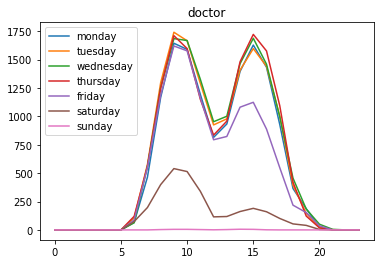

In [43]:
plot_weekly_moments('doctor')

## Creating a Timestamped Map

![](https://media0.giphy.com/media/l4FGp6wKxMULON88U/giphy.gif?cid=790b76115cdd75aa3441494a4984671f&rid=giphy.gif)

Here's a warning before you keep going: these next steps generates a new kind of map using folium, here I'm trying a interesting feature called [TimestampedGeoJson](https://python-visualization.github.io/folium/plugins.html#folium.plugins.TimestampedGeoJson). This Folium's plugin makes possible to display an fancy map with a time slider. But... sometimes it becomes so heavy and for that use case I found is not a big deal. I have more than 50k circles, need to parse them to GeoJson string format big using a expensive for loop. That is something I don't like. Propably there is a better way to make this.

Now you are warned, go on.

In [0]:
natal_map = folium.Map(location=[-5.8313086, -35.2047059], zoom_start=13)

In [45]:
natal_places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 12 columns):
place_name    303 non-null object
place_id      303 non-null object
lat           303 non-null float64
lng           303 non-null float64
type          303 non-null object
monday        303 non-null object
tuesday       303 non-null object
wednesday     303 non-null object
thursday      303 non-null object
friday        303 non-null object
saturday      303 non-null object
sunday        303 non-null object
dtypes: float64(2), object(10)
memory usage: 28.5+ KB


In [46]:
natal_places2 = pd.melt(natal_places, id_vars=["place_name", "place_id", "lat", "lng", "type"], var_name="weekday", value_name="moments")
natal_places2.moments = [json.loads(moment) for moment in natal_places2.moments]

natal_places2['0'] = [moment[0] for moment in natal_places2.moments]
natal_places2

for hour in range(0, 24):
    natal_places2[str(hour)] = [moment[hour] for moment in natal_places2.moments]

natal_places3 = pd.melt(natal_places2, id_vars=["place_name", "place_id", "lat", "lng", "type", "weekday","moments"], var_name="hour", value_name="moment_value")

del natal_places3['moments']

natal_places3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50904 entries, 0 to 50903
Data columns (total 8 columns):
place_name      50904 non-null object
place_id        50904 non-null object
lat             50904 non-null float64
lng             50904 non-null float64
type            50904 non-null object
weekday         50904 non-null object
hour            50904 non-null object
moment_value    50904 non-null int64
dtypes: float64(2), int64(1), object(5)
memory usage: 3.1+ MB


In [47]:
def gen_date(row):
    print(row.weekday)

times = []
for index, row in natal_places3.iterrows():
    if row.weekday == 'monday': time = '05/06/2019 '
    if row.weekday == 'tuesday': time = '05/07/2019 '
    if row.weekday == 'wednesday': time = '05/08/2019 '
    if row.weekday == 'thursday': time = '05/09/2019 '
    if row.weekday == 'friday': time = '05/10/2019 '
    if row.weekday == 'saturday': time = '05/11/2019 '
    if row.weekday == 'sunday': time = '05/12/2019 '
    
    time += str(row.hour) + ':00'
    
    times.append(time)
    
natal_places3['time'] = times
natal_places3['time'] = pd.to_datetime(natal_places3['time'])
natal_places3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50904 entries, 0 to 50903
Data columns (total 9 columns):
place_name      50904 non-null object
place_id        50904 non-null object
lat             50904 non-null float64
lng             50904 non-null float64
type            50904 non-null object
weekday         50904 non-null object
hour            50904 non-null object
moment_value    50904 non-null int64
time            50904 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 3.5+ MB


At this point you can export the "natal_places3" dataset to a .csv file and drop it in the [kepler.gl](https://kepler.gl)

In [0]:
def create_geojson_features(df):
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row.lng, row.lat]
            },
            'properties': {
                'time': row['time'].date().__str__() + ' ' + row['time'].time().__str__(),
                'style': {'color': 'red'},
                'icon': 'circle',
                'iconstyle': {
                    'fillColor': 'red',
                    'fillOpacity': 0.6,
                    'stroke': True,
                    'radius': row.moment_value/10
                }
            }
        }
        features.append(feature)
    return features

natal_features = create_geojson_features(natal_places3)

In [49]:
natal_features[25000]

{'geometry': {'coordinates': [-35.19618349999999, -5.7880677999999985],
  'type': 'Point'},
 'properties': {'icon': 'circle',
  'iconstyle': {'fillColor': 'red',
   'fillOpacity': 0.6,
   'radius': 10.0,
   'stroke': True},
  'style': {'color': 'red'},
  'time': '2019-05-11 11:00:00'},
 'type': 'Feature'}

In [0]:
TimestampedGeoJson(
    {'type': 'FeatureCollection',
    'features': natal_features},
    period='PT1H',
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='DD HH',
    time_slider_drag_update=True
).add_to(natal_map)
natal_map.save('natal_map.html')

![](https://media3.giphy.com/media/Bh45DNX3kz5Re/giphy.gif?cid=790b76115cdd75ec43426637634d5940&rid=giphy.gif)